In [ ]:
""" Symbolically solve the system of equations to express everything in
    [H+]. Then, use the numerical solver to just find pH. This vastly reduces
    the LUT size. 
"""
import sympy as sp

# Define the symbolic variables
h, oh, hco3, co3, ca, mg, na, k, al = sp.symbols('h oh hco3 co3 ca mg na k al')

# Define the parameters
b0, co2_atm, beta_h, beta1, beta2, beta3, beta4, beta5, kex1, kex2, kex3, kex4, kex5 = sp.symbols('b0 co2_atm beta_h beta1 beta2 beta3 beta4 beta5 kex1 kex2 kex3 kex4 kex5')
valence_Ca2, valence_Mg2, valence_Na, valence_K, valence_Al3 = sp.symbols('valence_Ca2 valence_Mg2 valence_Na valence_K valence_Al3')

# Define the equations
eq1 = sp.Eq(h * hco3 / co2_atm, 10**(-7.8136))
eq2 = sp.Eq(h * co3 / hco3, 10**(-10.3288))
eq3 = sp.Eq(h * oh, 1e-14)
eq4 = sp.Eq(h / beta_h * (beta1 / ca)**valence_Ca2, kex1)
eq5 = sp.Eq(h / beta_h * (beta2 / mg)**valence_Mg2, kex2)
eq6 = sp.Eq(h / beta_h * (beta3 / na)**valence_Na, kex3)
eq7 = sp.Eq(h / beta_h * (beta4 / k)**valence_K, kex4)
eq8 = sp.Eq(h / beta_h * (beta5 / al)**valence_Al3, kex5)
eq9 = sp.Eq(h - oh - hco3 - 2*co3 + 2*ca + 2*mg + na + k + 3*al, b0)

# Solve the equations symbolically for the unknowns in terms of h
solutions = sp.solve((eq1, eq2, eq3, eq4, eq5, eq6, eq7, eq8, eq9), (oh, hco3, co3, ca, mg, na, k, al))

# Display the solutions
solutions

In [ ]:
solutions[-1][-1]

In [1]:
""" Solution process

This have to be run over a computational node; jupyter note book is extremely slow
"""
# site-specific but time-constant parameters
# layer: 1-6, in order
site = 'UC_Davis'
if site == 'UC_Davis':
    co2_atm = 284.7 * 1e-6
    b0 = [1.1521680019276745E-004, 1.1420958624669067E-004, 1.4500538731595112E-004, 
          1.3131324215997722E-004, 1.3570195973452461E-004, 3.6638478151540603]
    log_kex1 = [-2.657813781, -2.655284289, -2.673342101, -2.690331797, -2.702951644, -2.711483988]
    log_kex2 = [-2.710111788, -2.707537832, -2.725917574, -2.743219456, -2.756076795, -2.76477233]
    log_kex3 = [-3.006006528, -3.003143469, -3.023580729, -3.042805303, -3.057082898, -3.066734974]
    log_kex4 = [-2.000498809, -1.998604044, -2.012138352, -2.02488813, -2.034368246, -2.04078232]
    log_kex5 = [-2.480635891, -2.478284394, -2.495079461, -2.510897516, -2.522656966, -2.53061222]

In [2]:
# from scipy.optimize import minimize
import numpy as np
import itertools as it
from tqdm import tqdm
import multiprocessing as mp

def objective(
    soil_ph,
    b0, co2_atm, beta1, beta2, beta3, beta4, beta5, kex1, kex2, kex3, kex4, kex5
):
    valence = {'Ca2+': 2, 'Mg2+': 2, 'Na+': 1, 'K+': 1, 'Al3+': 3}

    h = 10**(-soil_ph)
    beta_h = 1 - beta1 - beta2 - beta3 - beta4 - beta5

    al_RHS = 1/3*(b0 - 2*beta1/(beta_h*kex1/h)**(1/valence['Ca2+']) - 2*beta2/(beta_h*kex2/h)**(1/valence['Mg2+']) - beta3/(beta_h*kex3/h)**(1/valence['Na+']) - beta4/(beta_h*kex4/h)**(1/valence['K+']) + 1.53603106838503e-8*co2_atm/h + 7.20443620415286e-19*co2_atm/h**2 - h + 1e-14/h)
    al_LHS = beta5/(beta_h*kex5/h)**(1/valence['Al3+'])

    return abs(al_RHS - al_LHS) / (0.5*abs(al_RHS) + 0.5*abs(al_LHS))


def find_solution(args):
    layerid = args[-2]
    betaid = args[-1]
    args = args[:-2]

    # use a simple grid search to find the correct pH
    grid_search = np.linspace(0.5, 13.5, 501)

    count = 0
    err = 1
    while (err > 1e-3) and (count < 100):
        obj_value = []
        for soil_ph in grid_search:
            obj_value.append(objective(soil_ph, *args))
        best = np.argmin(np.abs(obj_value))

        # the best point is not guaranteeed to be between
        # the best and the second best when the mesh is
        # too coarse! 
        # arr = np.delete(np.abs(obj_value), best)
        # second_best = np.argmin(arr)
        # if second_best >= best:
        #     second_best = second_best + 1
        # best = grid_search[best]
        # second_best = grid_search[second_best]

        best_left = grid_search[max(best-5, 0)]
        best_right = grid_search[min(best+5, len(grid_search)-1)]
        best = grid_search[best]

        err = objective(best, *args)

        grid_search = np.linspace(best_left, best_right, 501 + int(501*err))
        count = count + 1

        # DEBUG
        # print(count, err, best_left, best_right)

    return (best, err, count, layerid, betaid)

In [ ]:
# Create the parameter ranges to search over
layer_list = range(1, 7)

beta1_grid = np.arange(1e-2, 1 + 1.1e-2, 0.05)
beta2_grid = np.arange(1e-2, 1 + 1.1e-2, 0.05)
beta3_grid = np.arange(1e-2, 1 + 1.1e-2, 0.05)
beta4_grid = np.arange(1e-2, 1 + 1.1e-2, 0.05)
beta5_grid = np.arange(1e-2, 1 + 1.1e-2, 0.05)

grid_values = []
for beta1, beta2, beta3, beta4, beta5 in \
    it.product(beta1_grid, beta2_grid, beta3_grid, beta4_grid, beta5_grid):
    # threshold accomodates the 1.05's 
    if (beta1 + beta2 + beta3 + beta4 + beta5) < 1:
        index = int(beta1/0.05) * 1e8 + int(beta2/0.05) * 1e6 + int(beta3/0.05) * 1e4 \
            + int(beta4/0.05) * 1e2 + int(beta5/0.05)
        grid_values.append([index, beta1, beta2, beta3, beta4, beta5])

# Create the list of arguments to run the root finding code
args_list = []
for (i, layer), (j, (_, beta1, beta2, beta3, beta4, beta5)) in \
    it.product(enumerate(layer_list), enumerate(grid_values)):

    args = b0[layer-1], co2_atm, beta1, beta2, beta3, beta4, beta5, \
           10**log_kex1[layer-1], 10**log_kex2[layer-1], 10**log_kex3[layer-1], \
           10**log_kex4[layer-1], 10**log_kex5[layer-1], i, j

    args_list.append(args)

# Collect the results
p = mp.Pool(mp.cpu_count())
# results = p.map_async(find_solution, args_list)
results = list(tqdm(p.imap(find_solution, args_list), total=len(args_list)))
p.close()
p.join()

# best pH
solved_pH = np.full([len(grid_values), len(layer_list)], np.nan)
# err relative to 0
solved_err = np.full([len(grid_values), len(layer_list)], np.nan)
# number of iterations the solver took
solved_iter = np.full([len(grid_values), len(layer_list)], np.nan)
# acid saturation; I guess this may be related to err
beta_h = np.full([len(grid_values), len(layer_list)], np.nan) 
for rs in results:
    j = rs[-1] # betaid
    i = rs[-2] # layerid
    solved_pH[j,i] = rs[0]
    solved_err[j,i] = rs[1]
    solved_iter[j,i] = rs[2]
    beta_h[j,i] = 1 - sum(grid_values[j][1:])

In [ ]:
# Diagnostic plots
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 1, figsize = (10,6))
for i in range(6):
    ax = axes.flat[i]
    ax.plot(solved_pH[:, i])
fig.savefig('solved_pH.png', dpi = 600.)
plt.close(fig)

fig, axes = plt.subplots(6, 1, figsize = (10,6))
for i in range(6):
    ax = axes.flat[i]
    ax.plot(solved_err[:, i])
fig.savefig('solved_err.png', dpi = 600.)
plt.close(fig)

fig, axes = plt.subplots(6, 1, figsize = (10,6))
for i in range(6):
    ax = axes.flat[i]
    ax.plot(solved_iter[:, i])
fig.savefig('solved_iter.png', dpi = 600.)
plt.close(fig)

fig, axes = plt.subplots(3, 2, figsize = (20,20))
for i in range(6):
    ax = axes.flat[i]
    ax.plot(beta_h[:, i], solved_err[:, i], 'o')
fig.savefig('solved_betaherr.png', dpi = 600.)
plt.close(fig)

In [ ]:
# Save the LUT
import os
import pandas as pd

LUT = pd.DataFrame(
    np.hstack([np.array(grid_values), solved_pH]), 
    columns = ['grid_id', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5', 
               'layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6']
)
LUT = LUT.set_index('grid_id')
LUT.index = LUT.index.astype(int)
LUT.to_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'dynpH_LUT.csv'))

In [ ]:
""" Worker code; only for checking why things are bad
"""

"""import matplotlib.pyplot as plt

layer = 6
i = layer-1
bad = 0 # np.where(solved_err[:, layer-1] > 0.5)[0][0]
j, beta1, beta2, beta3, beta4, beta5 = grid_values[bad]

print(beta1, beta2, beta3, beta4, beta5)

args = b0[layer-1], co2_atm, beta1, beta2, beta3, beta4, beta5, \
       10**log_kex1[layer-1], 10**log_kex2[layer-1], 10**log_kex3[layer-1], \
       10**log_kex4[layer-1], 10**log_kex5[layer-1], i, j
result = find_solution(args)
result

soil_ph = np.linspace(0.5, 0.75, 101)
val = objective(soil_ph, *args[:-2])
plt.plot(soil_ph, val)"""

In [52]:
# Test the accuracy of the LUT by randomly picking some values
from scipy.stats.qmc import LatinHypercube
import pandas as pd
import os

eps = 0.01 # the beta factors are constrained to be above this

npts = LatinHypercube(5, seed = 125).random(n = 10000)
npts = np.array([npts[i,:] for i in range(npts.shape[0]) if (np.sum(npts[i,:]) <= 1) & \
                (np.min(npts[i,:]) >= eps)])
LUT = pd.read_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'dynpH_LUT.csv'),
                  index_col = 0)

In [103]:
def pentainear_interpolate(pt, grid_pts, grid_vals):
    # gradually reduce the dimensions

    prev_interp = grid_vals.copy()
    prev_grids = grid_pts.copy()

    # print(pt)

    for i in range(5):
        left_weight = (1 - pt[i])
        right_weight = pt[i]

        left_vals = prev_interp[prev_grids[:, i] == 0]
        right_vals = prev_interp[prev_grids[:, i] == 1]

        left_pts = prev_grids[prev_grids[:, i] == 0, :]
        right_pts = prev_grids[prev_grids[:, i] == 1, :]

        if right_pts.shape[0] == 0:
            prev_interp = left_vals
            prev_grids = left_pts
            continue

        new_interp = np.full(left_pts.shape[0], np.nan)
        for row in range(left_pts.shape[0]):
            # pts from the lower bound
            left_row = np.delete(left_pts[row, :], i)

            right_pts_temp = np.delete(right_pts, i, 1)
            filt = np.full(right_pts_temp.shape[0], True)
            for j, elem in enumerate(left_row):
                filt = filt & (right_pts_temp[:, j] == elem)

            # if uneven, fill from the left
            # (note only the upper bound may be missing due to
            #  the sum of beta < 1 condition)
            if np.sum(filt) == 0:
                new_interp[row] = left_vals[row]
            elif np.sum(filt) == 1:
                new_interp[row] = left_vals[row] * left_weight + \
                    right_vals[np.where(filt)[0][0]] * right_weight
                #print(i, left_pts[row, :], right_pts[filt, :], 
                #      left_weight, right_weight, left_vals[row], right_vals[np.where(filt)[0][0]])
            else:
                raise Exception('too many matching upper bound values')

        prev_interp = new_interp
        prev_grids = left_pts

    return prev_interp


def apply_LUT(layer, beta_list):
    # note: subtract the minimum offset
    column = f'layer{layer}'

    grid_pts = []
    grid_vals = []
    for i,j,k,m,n in it.product(range(2), range(2), range(2), range(2), range(2)):
        # limit the upper bound to < 1
        if np.sum(beta_list) + 0.05*(i+j+k+m+n) > 1:
                continue
        pt = [int((beta_list[0]-eps)/0.05) + i, 
                int((beta_list[1]-eps)/0.05) + j,
                int((beta_list[2]-eps)/0.05) + k,
                int((beta_list[3]-eps)/0.05) + m,
                int((beta_list[4]-eps)/0.05) + n]
        index = pt[0] * 1e8 + pt[1] * 1e6 + pt[2] * 1e4 + pt[3] * 1e2 + pt[4]
        grid_vals.append(LUT.loc[index, column])
        grid_pts.append([i,j,k,m,n])
    grid_pts = np.array(grid_pts)
    grid_vals = np.array(grid_vals)
    pt = (np.array(beta_list)-eps)/0.05
    pt = pt - np.floor(pt)
    result = pentainear_interpolate(pt, grid_pts, grid_vals)

    return result

In [104]:
test_err = np.full([npts.shape[0], 6], np.nan)
for i,j in it.product(range(6), range(npts.shape[0])):
    layer = i + 1
    beta_list = list(npts[j, :])
    result = apply_LUT(layer, beta_list)

    args = b0[layer-1], co2_atm, beta_list[0], beta_list[1], \
           beta_list[2], beta_list[3], beta_list[4], \
           10**log_kex1[layer-1], 10**log_kex2[layer-1], 10**log_kex3[layer-1], \
           10**log_kex4[layer-1], 10**log_kex5[layer-1]

    test_err[j,i] = objective(result, *args)

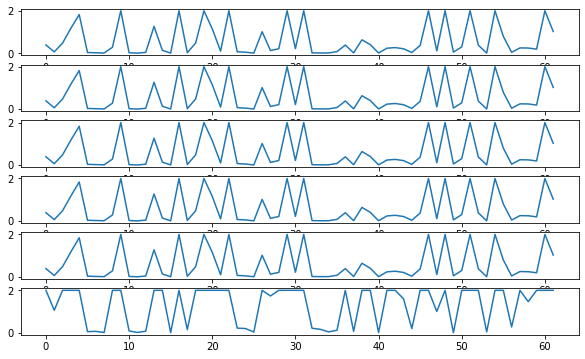

In [109]:
import matplotlib.pyplot as plt

# !!!!!!!!!!!!!!!!! 
# the LUT cannot be evenly spaced. Some places need more values, elsewhere need fewer values. 

fig, axes = plt.subplots(6, 1, figsize = (10,6))
for i in range(6):
    axes.flat[i].plot(test_err[:, i])